# Feed-forward Artificial Neural Networks


In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import time

## Learning the XOR function


Let us consider the XOR ("exclusive or") function. The [truth table](https://en.wikipedia.org/wiki/Exclusive_or#Truth_table) of the XOR function is:


In [2]:
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([[0], [1], [1], [0]])

We consider a fully connected ANN with the following architechture and with $\tanh(\cdot)$ as activation function:


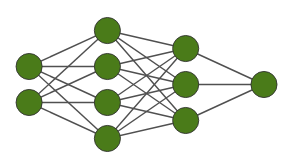


The input of the network are the truth values of the two inputs (0 = False, 1 = True). The output is the **likelihood** (the "probability") of the truth value of the result. Hence, we want the output to be in $[0, 1]$. For this reason, we apply the activation function also to the last layer, and we rescale the output between 0 and 1.

The architecture is defined by the following **hyperparameters**:


In [3]:
n1, n2, n3, n4 = 2, 4, 3, 1

Define the parameters (weights and biases) of the ANN.
Initialize the weights sampling from a standard normal distribution, and initialize to zero the biases.

Define both the weights and the biases as a 2-dimensional `numpy` array.


In [4]:
def random_params():
    np.random.seed(0)  # for reproducibility

    W1 = np.random.randn(n2, n1)
    # b1 = np.random.randn(n2, 1)
    b1 = jnp.zeros((n2, 1))
    W2 = np.random.randn(n3, n2)
    # b2 = np.random.randn(n3, 1)
    b2 = jnp.zeros((n3, 1))
    W3 = np.random.randn(n4, n3)
    # b3 = np.random.randn(n4, 1)
    b3 = jnp.zeros((n4, 1))

    params = [W1, b1, W2, b2, W3, b3]
    return params

In [5]:
params = random_params()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Define a function that implements the ANN:

```python
def ANN(x, params):
  ...
```

with inputs:

- `x`: num_samples by 2 `numpy` array
- `params`: list of the parameters
  and with output
- `y`: num_samples by 1 `numpy` array

Then, test the function on `inputs` and `params`.


In [6]:
def ANN(x, params):
    [W1, b1, W2, b2, W3, b3] = params
    z1 = x.T
    z2 = jnp.tanh(W1 @ z1 - b1)
    z3 = jnp.tanh(W2 @ z2 - b2)
    z4 = jnp.tanh(W3 @ z3 - b3)
    # print("z1: %dx%d" % z1.shape)
    # print("z2: %dx%d" % z2.shape)
    # print("z3: %dx%d" % z3.shape)
    # print("z4: %dx%d" % z4.shape)
    return 0.5 * (z4 + 1).transpose()

In [7]:
result = ANN(inputs, params)
result, result[0, 0], result[1, 0]

(Array([[0.5       ],
        [0.57224154],
        [0.107804  ],
        [0.10987768]], dtype=float32),
 Array(0.5, dtype=float32),
 Array(0.57224154, dtype=float32))

Print the truth table associated with the ANN.


In [8]:
def print_xor_results(params):
    for a in (0, 1):
        for b in (0, 1):
            out = ANN(jnp.array([[a, b]]), params)
            print("%d XOR %d --> %f" % (a, b, out))

In [9]:
params = random_params()
print_xor_results(params)

0 XOR 0 --> 0.500000
0 XOR 1 --> 0.572242
1 XOR 0 --> 0.107804
1 XOR 1 --> 0.109878


Define a function that computes the quadratic loss on a set of data:

```python
def loss_quadratic(x, y, params):
  ...
```

with inputs:

- `x`: num_samples by 2 `numpy` array
- `y`: num_samples by 1 `numpy` array
- `params`: list of the parameters
  and with output
- `loss`: scalar

Then, test the function on `inputs`, `outputs` and `params`.


In [10]:
def loss_quadratic(x, y, params):
    return jnp.sum((ANN(x, params) - y) ** 2)

In [11]:
loss_quadratic(inputs, outputs, params)

Array(1.2410641, dtype=float32)

Define a function that computes the cross-entropy loss on a set of data:

```python
def loss_crossentropy(x, y, params):
  ...
```

with inputs:

- `x`: num_samples by 2 `numpy` array
- `y`: num_samples by 1 `numpy` array
- `params`: list of the parameters
  and with output
- `loss`: scalar

Then, test the function on `inputs`, `outputs` and `params`.


In [12]:
def loss_crossentropy(x, y, params):
    results = ANN(x, params)
    return -jnp.sum(y * jnp.log(results) + (1 - y) * jnp.log(1 - results))

In [13]:
loss_crossentropy(inputs, outputs, params)

Array(3.5951784, dtype=float32)

Using the JIT module of JAX, compile both the losses defined above and their gradients w.r.t. the parameters.


In [14]:
grad_loss_quad = jax.grad(loss_quadratic, argnums=2)
loss_quad_jit = jax.jit(loss_quadratic)
grad_loss_quad_jit = jax.jit(grad_loss_quad)

grad1 = grad_loss_quad_jit(inputs, outputs, params)
print(type(grad1))
# grad[0]  # gradient of W1
# grad[1]  # gradient of b1
# grad[2]  # gradient of W2
# grad[3]  # gradient of b2
# grad[4]  # gradient of W3
# grad[5]  # gradient of b3

grad_loss_Xent = jax.grad(loss_crossentropy, argnums=2)
loss_Xent = jax.jit(loss_crossentropy)
grad_loss_Xent_jit = jax.jit(grad_loss_Xent)

grad2 = grad_loss_Xent_jit(inputs, outputs, params)
print(grad2)

<class 'list'>
[Array([[-0.14097498, -1.431664  ],
       [ 0.22063133,  0.04247307],
       [-0.00529687, -0.05339568],
       [ 0.72777605,  3.3548357 ]], dtype=float32), Array([[-0.47092414],
       [ 0.88254   ],
       [-0.12234492],
       [ 0.00929785]], dtype=float32), Array([[ 1.5942397 ,  2.7154102 , -0.8319982 ,  0.28539503],
       [-0.3884949 , -0.68005055,  0.23367347, -0.05733938],
       [-0.86071366, -1.1331575 , -0.10942245, -0.37438878]],      dtype=float32), Array([[-0.44397783],
       [ 0.0929912 ],
       [ 0.4642173 ]], dtype=float32), Array([[-1.4261078, -1.4345956, -1.355752 ]], dtype=float32), Array([[1.4201535]], dtype=float32)]


Implement the GD (gradient descent) method, with learning rate 0.1 and train the ANN, using either the quadratic or the cross-entropy loss function.
Collect the training history of both loss functions at each training epoch and plot them.

Finally, print the truth table associated with the ANN and compute its accuracy.


In [15]:
ANN(inputs, params)

Array([[0.5       ],
       [0.57224154],
       [0.107804  ],
       [0.10987768]], dtype=float32)

In [16]:
def optimize_params(
    inputs, outputs, params, loss_function, return_history, learning_rate, n_epoch
):
    # learning rate
    lam = learning_rate
    max_epoch = n_epoch
    tolerance = 1.0e-6

    grad_loss = jax.grad(loss_function, argnums=2)
    loss_jit = jax.jit(loss_function)
    grad_loss_jit = jax.jit(grad_loss)

    history = list()

    for k in range(max_epoch):
        grad = grad_loss_jit(inputs, outputs, params)
        norm = np.sum([np.linalg.norm(grad[i]) for i in range(len(grad))])
        if norm <= tolerance:
            break
        for i in range(len(grad)):
            params[i] -= lam * grad[i]

        history.append(loss_jit(inputs, outputs, params))

    print("Epoch reached: %d" % k)
    print("Tolerance achieved: %f" % norm)
    if not return_history:
        return params
    else:
        return params, history

Epoch reached: 1999
Tolerance achieved: 0.002572
Elapsed time: 0.818185 s
Accuracy: 99.22%
0 XOR 0 --> 0.004794
0 XOR 1 --> 0.993524
1 XOR 0 --> 0.988720
1 XOR 1 --> 0.008618


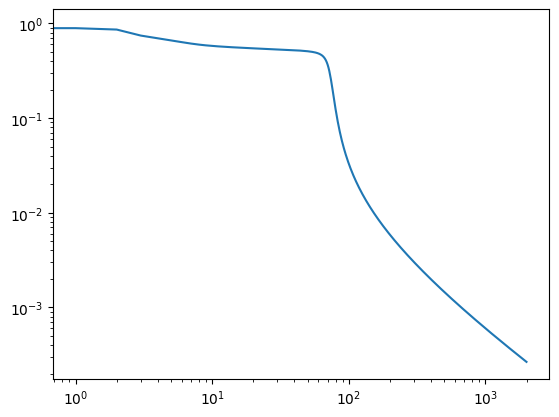

In [17]:
params = random_params()
ti = time.time()
opt_params, history_quad = optimize_params(
    inputs,
    outputs,
    params,
    loss_quadratic,
    return_history=True,
    learning_rate=0.1,
    n_epoch=2000,
)
tf = time.time()
print("Elapsed time: %f s" % (tf - ti))
y_grad = ANN(inputs, opt_params)
accuracy_grad = (1 - np.mean(np.abs(outputs - y_grad))) * 100
print("Accuracy: %1.2f%%" % accuracy_grad)
print_xor_results(opt_params)

plt.loglog(history_quad)

Epoch reached: 1999
Tolerance achieved: 0.004302
Elapsed time: 0.755801 s
Accuracy: 99.98%
0 XOR 0 --> 0.000080
0 XOR 1 --> 0.999850
1 XOR 0 --> 0.999621
1 XOR 1 --> 0.000226


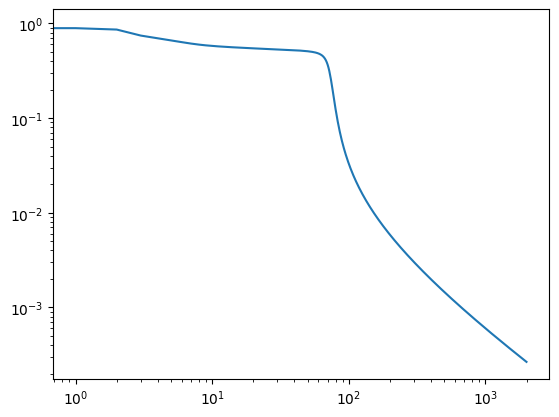

In [18]:
params = random_params()
ti = time.time()
opt_params, history_Xent = optimize_params(
    inputs,
    outputs,
    params,
    loss_crossentropy,
    return_history=True,
    learning_rate=0.1,
    n_epoch=2000,
)
tf = time.time()
print("Elapsed time: %f s" % (tf - ti))
y_Xent = ANN(inputs, opt_params)
accuracy_Xent = (1 - np.mean(np.abs(outputs - y_Xent))) * 100
print("Accuracy: %1.2f%%" % accuracy_Xent)
print_xor_results(opt_params)

plt.loglog(history_quad)

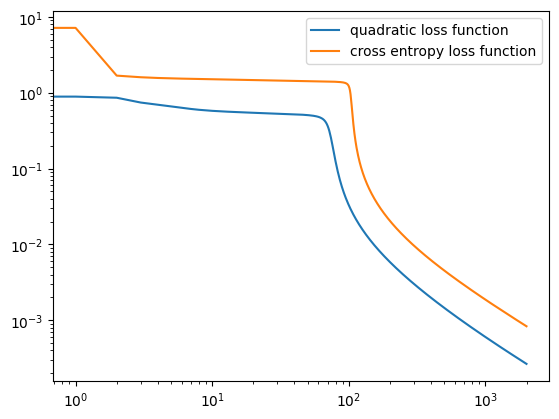

In [19]:
plt.loglog(history_quad, label="quadratic loss function")
plt.loglog(history_Xent, label="cross entropy loss function")
plt.legend()